In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir, getcwd, chdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import operator
import xgboost as xgb
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException
from xgboost.core import STRING_TYPES

import diff_predictor
from diff_predictor import data_process
from diff_predictor.predxgboost import train


/Users/nelsschimek/anaconda3/envs/diff_predictor_env/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/nelsschimek/anaconda3/envs/diff_predictor_env/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-

In [4]:
from azureml.core import Workspace, Dataset

subscription_id = '9c49afdd-cccb-44e2-a4eb-5b2f941c774c'
resource_group = 'schimek_cloud'
workspace_name = 'schimek_mpt_eastus2'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='age_mpt_feature_data')
dataset.download(target_path='.', overwrite=True)

['/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P14_40nm_s1_v1.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P14_40nm_s2_v4.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P21_40nm_s1_v2.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P21_40nm_s2_v5.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P28_40nm_s1_v3.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P28_40nm_s3_v1.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P35_brain_2_slice_1_vid_4.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P35_brain_2_slice_3_vid_2.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_

In [5]:
filelist = []
for file in dataset.to_path():
    filelist.append(file)
print('showing five path examples')
print(filelist[0:5])

showing five path examples
['/features_P14_40nm_s1_v1.csv', '/features_P14_40nm_s1_v2.csv', '/features_P14_40nm_s1_v3.csv', '/features_P14_40nm_s1_v4.csv', '/features_P14_40nm_s1_v5.csv']


In [6]:
datasetpath = getcwd()


In [7]:
print('running generate_fullstats function on subset filelist')
fstats_tot = data_process.generate_fullstats(datasetpath, filelist, ['P14', 'P35', 'P70'], 'age')
print(fstats_tot.head())

running generate_fullstats function on subset filelist
Adding file /features_P14_40nm_s1_v1.csv size: (793, 91)
Adding file /features_P14_40nm_s1_v2.csv size: (1356, 91)
Adding file /features_P14_40nm_s1_v3.csv size: (519, 91)
Adding file /features_P14_40nm_s1_v4.csv size: (140, 91)
Adding file /features_P14_40nm_s1_v5.csv size: (268, 91)
Adding file /features_P14_40nm_s2_v1.csv size: (568, 91)
Adding file /features_P14_40nm_s2_v2.csv size: (938, 91)
Adding file /features_P14_40nm_s2_v3.csv size: (220, 91)
Adding file /features_P14_40nm_s2_v4.csv size: (162, 91)
Adding file /features_P14_40nm_s2_v5.csv size: (258, 91)
Adding file /features_P14_40nm_s3_v1.csv size: (151, 91)
Adding file /features_P14_40nm_s3_v2.csv size: (243, 91)
Adding file /features_P14_40nm_s3_v3.csv size: (323, 91)
Adding file /features_P14_40nm_s3_v4.csv size: (113, 91)
Adding file /features_P14_40nm_s3_v5.csv size: (389, 91)
Adding file /features_P35_brain_2_slice_1_vid_1.csv size: (416, 91)
Adding file /features

In [12]:
feature_list = [
  
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'age'

In [18]:
best_param = {'max_depth': 2, 'eta': 0.01, 'min_child_weight': 0, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 0.2, 'subsample': 0.6, 'colsample_bytree': 1.0, 'eval_metric': 'mlogloss'}


In [23]:
import random

random.seed(42)
print(random.randint(a=1, b=2000))
print(random.randint(a=1, b=2000))

1310
229


In [ ]:
acc_list = []
true_label_list = []
preds_list = []
for i in range(50):
#     sampled_filelist = []
#     class_lens = [0, 15, 30, 45, 60, 75] # this is specific to the age data set!
#     for i in range(len(class_lens)-1):
#         rand_integers = random.sample(set(np.arange(class_lens[i], class_lens[i+1])), 15)
#         for rand_int in rand_integers:
#             sampled_filelist.append(filelist[rand_int])
    fstats_tot = data_process.generate_fullstats(datasetpath, filelist, ['P14', 'P35', 'P70'], 'age')
    ecm = fstats_tot[feature_list + [target, 'Track_ID', 'X', 'Y', 'frames', 'dist_tot', 'dist_net']]
    ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)] 
    bal_ecm = data_process.balance_data(ecm, target)
    sampled_df = data_process.bin_data(bal_ecm)
    label_df = sampled_df['age']
    features_df = sampled_df.drop(['age', 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID', 'frames', 'dist_tot', 'dist_net'], axis=1)
    features = features_df.columns

    random.seed(1234)
    seed = random.randint(a=1, b=2000)
    print(seed)
    
    train_split = 0.8
    test_split = 0.5

    le = preprocessing.LabelEncoder()
    sampled_df['encoded_target'] = le.fit_transform(sampled_df[target])

    training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

    X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
    X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
    X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    y_val = X_val['encoded_target']

    dtrain = xgb.DMatrix(X_train[features], label=y_train)
    dtest = xgb.DMatrix(X_test[features], label=y_test)
    dval = xgb.DMatrix(X_val[features], label=y_val)
    booster, acc, true_label, preds = train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=743)
    acc_list.append(acc)
    true_label_list.append(true_label)
    preds_list.append(preds)



In [25]:
import os
output_dict = {'Accuracies': acc_list,
               'True Labels': true_label_list,
               'Preds': preds_list,
}
df = pd.DataFrame(output_dict)
# Save a sample of the data in the outputs folder (which gets uploaded automatically)
os.makedirs('outputs', exist_ok=True)
df.to_csv("outputs/run_data.csv", index=False, header=True)

In [41]:
acc_np_array = np.array(acc_list)
acc_mean = np.mean(acc_np_array)
acc_std = np.std(acc_np_array)
print('mean accuracy: ' + str(acc_mean))
print('std accuracy: ' + str(acc_std))

mean accuracy: 0.6881547231071066
std accuracy: 0.01903305149932289


In [30]:
sorted_acc_list = sorted(acc_list)
sorted_acc_list[24:26]

[0.6878612716763006, 0.6884589726484323]

In [38]:
acc_list.index(sorted_acc_list[24])

48

In [40]:
print(classification_report(true_label_list[48], preds_list[48], target_names=['P14', 'P35', 'P70']))

              precision    recall  f1-score   support

         P14       0.85      0.85      0.85       552
         P35       0.55      0.40      0.47       505
         P70       0.63      0.80      0.70       500

    accuracy                           0.69      1557
   macro avg       0.68      0.68      0.67      1557
weighted avg       0.68      0.69      0.68      1557



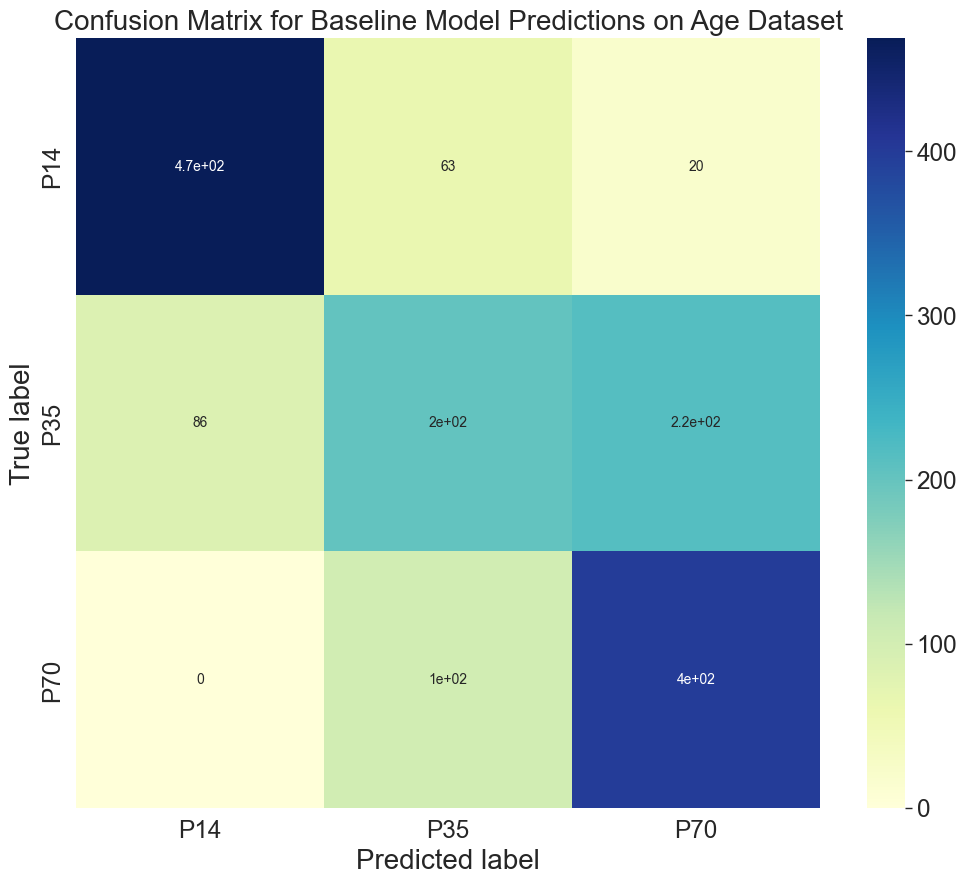

In [47]:
#make confusion matrix

import seaborn as sns

class_names = le.classes_
metrics.confusion_matrix(true_label_list[48], preds_list[48])
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(true_label_list[48], preds_list[48])
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set_context("paper", font_scale=2) #font_scale=1.4)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="YlGnBu")
plt.ylabel('True label', fontsize=20)#, weight='bold')
plt.xlabel('Predicted label', fontsize=20)#, weight='bold')
plt.title('Confusion Matrix for Baseline Model Predictions on Age Dataset', fontsize=20)#, weight='bold')

plt.show()
